Intitalize All modules

In [8]:
from PIL import Image
import numpy as np
import torch
import torch
import os
import torch.nn as nn
import torch.nn.functional as F

model_root_path = 'model/tidl2'

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'mps'

# 建立一個包裝的nn.Module
class WrapperModule(torch.nn.Module):
    def __init__(self, scripted_model):
        super().__init__()
        self.scripted_model = scripted_model

    def forward(self, x):
        # 將輸入直接饋入scripted model
        return self.scripted_model(x)

class TRTModel_pre(nn.Module):
    def __init__(self, backbone, neck, multi_scale_id, n_voxels, neck_fuse_0):
        super().__init__()
        # 如果 model 本身是個 nn.Module 或可以視為一個子模組
        # 請確定 model 是一個 nn.Module 或已 wrap 在 nn.Module 裡面
        self.backbone = backbone
        self.neck = neck
        self.multi_scale_id = multi_scale_id
        self.n_voxels = n_voxels
        self.neck_fuse_0 = neck_fuse_0
        # 現在 FX tracing 時就會知道 self.model_submodule 是一個子模組
        self.seq = 1
        self.nv = 6
        self.batch_size = 1

    def forward(self, img):
        #img = img.reshape([-1] + list(img.shape)[2:])
        x = self.backbone(img)
        mlvl_feats = self.neck(x)
        mlvl_feats = list(mlvl_feats)

        if self.multi_scale_id is not None:
            mlvl_feats_ = []
            for msid in self.multi_scale_id:
                # fpn output fusion
                if getattr(self, f'neck_fuse_{msid}', None) is not None:
                    fuse_feats = [mlvl_feats[msid]]
                    for i in range(msid + 1, len(mlvl_feats)):
                        resized_feat = F.interpolate(
                            mlvl_feats[i], 
                            size=mlvl_feats[msid].size()[2:], 
                            mode="bilinear", 
                            align_corners=False
                        )
                        fuse_feats.append(resized_feat)
                
                    if len(fuse_feats) > 1:
                        fuse_feats = torch.cat(fuse_feats, dim=1)
                    else:
                        fuse_feats = fuse_feats[0]
                    fuse_feats = getattr(self, f'neck_fuse_{msid}')(fuse_feats)
                    mlvl_feats_.append(fuse_feats)
                else:
                    print(f"msid: {msid} is not in neck_fuses")
                    mlvl_feats_.append(mlvl_feats[msid])
            mlvl_feats = mlvl_feats_
        # v3 bev ms
        if isinstance(self.n_voxels, list) and len(mlvl_feats) < len(self.n_voxels):
            pad_feats = len(self.n_voxels) - len(mlvl_feats)
            for _ in range(pad_feats):
                mlvl_feats.append(mlvl_feats[0])

        # only support one layer feature
        assert len(mlvl_feats) == 1, "only support one layer feature !"
        mlvl_feat =  mlvl_feats[0]

        return mlvl_feat



def preprocess_images(image_paths, input_size, mean, std):
    images = []
    for path in image_paths:
        # 讀取並確保RGB
        img = Image.open(path).convert('RGB')
        new_img_width = input_size[1]
        new_img_height = float(new_img_width) / img.size[0] * img.size[1]
        
        # Resize
        img_resized = img.resize((int(new_img_width), int(new_img_height)), Image.LANCZOS)
        crop_x = (img_resized.size[0] - input_size[1]) / 2
        crop_y = (img_resized.size[1] - input_size[0]) / 2

        crop_img = img_resized.crop((crop_x, crop_y, crop_x+input_size[1], crop_y+input_size[0]))
        assert crop_img.size[0] == input_size[1] and crop_img.size[1] == input_size[0]

        # 轉為Tensor(H,W,C)
        img_tensor = torch.from_numpy(np.array(crop_img)).float().to(DEVICE)  # shape: (H, W, C)
        
        # 减均值，除標準差 (mean,std為C维度大小的tensor)
        # 須先將Img tensor從 HWC -> CHW
        img_tensor = img_tensor.permute(2,0,1)  # (C,H,W)
        
        # Broadcasting: (C,H,W) - (C,1,1) / (C,1,1)
        # 將mean, std reshape成 (C,1,1)
        mean = mean.view(-1,1,1)
        std = std.view(-1,1,1)
        
        img_normalized = (img_tensor - mean) / std
        
        images.append(img_normalized)

    # 將所有影像打包成 (N, C, H, W)
    batch_images = torch.stack(images, dim=0)
    return batch_images
    
batch_size = 6
num_cameras = 6
channels = 3
height = 256
width = 704


output_features = np.zeros((batch_size, 64, 64, 176), dtype=np.float32)
accu_time = 0

def next_image_paths(imgid):
    return [
        f'data/samples/front/front_{imgid}.jpg',
        f'data/samples/front_right/front_right_{imgid}.jpg',
        f'data/samples/front_left/front_left_{imgid}.jpg',
        f'data/samples/back/back_{imgid}.jpg',
        f'data/samples/back_left/back_left_{imgid}.jpg',
        f'data/samples/back_right/back_right_{imgid}.jpg',
    ]

# 假设您的模型期望输入尺寸为 256x704
input_size = (256, 704)  # (height, width)

# 使用与训练时相同的均值和标准差
mean = torch.tensor([123.675, 116.28, 103.53], dtype=torch.float32).to(DEVICE)
std = torch.tensor([58.395, 57.12, 57.375], dtype=torch.float32).to(DEVICE)





Verify the fastbev_pre_trt.pth

In [ ]:
import matplotlib.pyplot as plt

model = torch.load(os.path.join(model_root_path, "fastbev_pre_trt.pth"), weights_only=False).to(DEVICE)
model.eval()
# 用包裝過的模型執行PTQ
#wrapper = WrapperModule(model)
#onnx_model = onnx.load(os.path.join(model_root_path, "fastbev_pre_trt.onnx"))
#pytorch_model = ConvertModel(onnx_model).to(DEVICE)
model_int8 = model

num_samples = 10
sample_output_features = np.zeros((num_samples, batch_size, 64, 64, 176), dtype=np.float32)

output_features = np.zeros((batch_size, 64, 64, 176), dtype=np.float32)
for imgid in range(1, 1):
    img_paths = next_image_paths(imgid)
    batch_images = preprocess_images(img_paths, input_size, mean, std)
    for i in range(batch_size):
        single_input_tensor = batch_images[i].unsqueeze(0).float()
        #print(i, single_input_tensor.shape)
        with torch.no_grad():
            backbone_output = model_int8(single_input_tensor)
            output_features[i] = backbone_output.cpu().numpy()    
    sample_output_features[imgid-1] = output_features     

num_images = output_features.shape[0]
num_channels = 16  # 只显示前 16 个通道

grid_rows = num_images
grid_cols = num_channels
for sample_idx in range(1):
    plt.close()
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 1.5, grid_rows * 1.5))
    output_features = sample_output_features[sample_idx]
    for img_idx in range(num_images):
        for ch_idx in range(num_channels):
            ax = axes[img_idx, ch_idx]
            feature_map = output_features[img_idx, ch_idx, :, :]
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
    plt.tight_layout()
    plt.show() 

PTC for fastbev_pre_trt

In [12]:
import edgeai_torchmodelopt
from tqdm import tqdm

model = torch.load(os.path.join(model_root_path, "fastbev_pre_trt.pth"), weights_only=False).to(DEVICE)
model.eval()
model_int8 = edgeai_torchmodelopt.xmodelopt.quantization.v2.PTCFxModule(model, backend='qnnpack', bias_calibration_factor=0.01, num_batch_norm_update_epochs=1, num_observer_update_epochs=2)

num_samples = 50
num_epochs = 3

for e in range(num_epochs):
    print(f"Epoch {e+1}/{num_epochs}")
    model_int8.train()
    for s in tqdm(range(num_samples)):    
        img_paths = next_image_paths(s+1)
        batch_images = preprocess_images(img_paths, input_size, mean, std)
        for i in range(batch_size):
            single_input_tensor = batch_images[i].unsqueeze(0).float()
            backbone_output = model_int8(single_input_tensor)


model_int8.export(batch_images[0].reshape(1,channels, height, width) ,os.path.join(model_root_path, "fastbev_pre_trt_int8.onnx"))

Model Preparation is now complete! 
Epoch 1/3


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


Epoch 2/3


100%|██████████| 50/50 [01:51<00:00,  2.23s/it]


Epoch 3/3


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]
<eval_with_key>.35:88: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at ../aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  cat = torch.cat([neck_fpn_convs_0_conv, interpolate_3, interpolate_4, interpolate_5], dim = 1);  neck_fpn_convs_0_conv = interpolate_3 = interpolate_4 = interpolate_5 = None
/workspace/miniconda3/envs/tidl/lib/python3.10/site-packages/torch/jit/_trace.py:477: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at ../aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  outs = wrap_retval(mod(*_clone_inputs(inputs)))
/workspace/miniconda3/envs/tidl/lib/python3.10/site-packages/torch/nn/modules/module.py:1747: UserWarning: All inputs of this cat operator must share the same quantiza

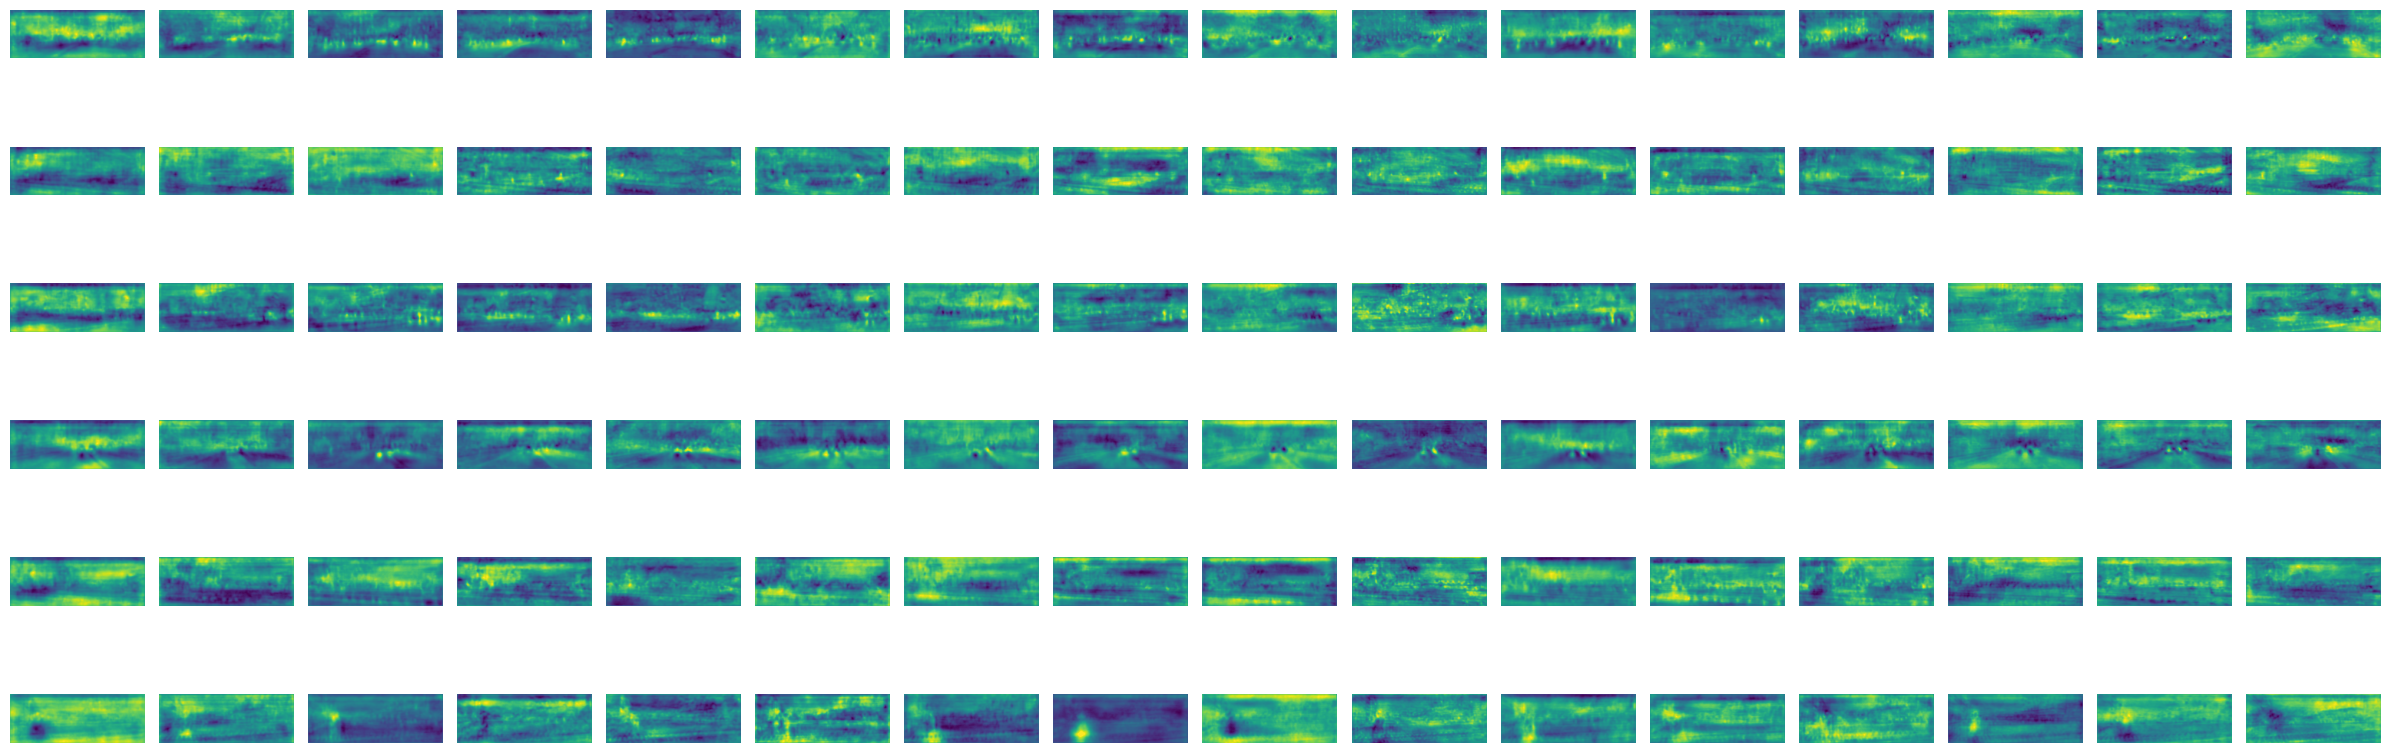

In [13]:
import onnxruntime as ort
import matplotlib.pyplot as plt
import time

backbone_model_path =  os.path.join(model_root_path, "fastbev_pre_trt_int8.onnx")
backbone_session = ort.InferenceSession(backbone_model_path, providers=['CPUExecutionProvider'])
backbone_output_name = backbone_session.get_outputs()[0].name
backbone_input_name = backbone_session.get_inputs()[0].name
accu_time = 0
output_features = np.zeros((batch_size, 64, 64, 176), dtype=np.float32)

img_paths = next_image_paths(1)
batch_images = preprocess_images(img_paths, input_size, mean, std)
for i in range(batch_size):
    start = time.time()
    backbone_output = backbone_session.run(
        [backbone_output_name],
        {backbone_input_name: batch_images[i].cpu().numpy().reshape(1,channels, height, width)}
    )
    accu_time += time.time() - start
    output_features[i] = backbone_output[0][0]


num_images = output_features.shape[0]
num_channels = 16 

grid_rows = num_images
grid_cols = num_channels

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 1.5, grid_rows * 1.5))
for img_idx in range(num_images):
    for ch_idx in range(num_channels):
        ax = axes[img_idx, ch_idx]
        feature_map = output_features[img_idx, ch_idx, :, :]
        ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
plt.tight_layout()
plt.show() 